In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as vF
from torchvision.ops import box_convert
from einops import rearrange
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Dataset and DataLoader

In [61]:
# from datasets import load_dataset
# train_dataset = load_dataset(import os
import torch
import torchvision.transforms.v2
from torch.utils.data.dataset import Dataset
import xml.etree.ElementTree as ET
from torchvision import tv_tensors
from torchvision.io import read_image


def load_images_and_anns(im_sets, label2idx, ann_fname, split):
    r"""
    Method to get the xml files and for each file
    get all the objects and their ground truth detection
    information for the dataset
    :param im_sets: Sets of images to consider
    :param label2idx: Class Name to index mapping for dataset
    :param ann_fname: txt file containing image names{trainval.txt/test.txt}
    :param split: train/test
    :return:
    """
    im_infos = []
    for im_set in im_sets:
        im_names = []
        # Fetch all image names in txt file for this imageset
        for line in open(os.path.join(
                im_set, 'ImageSets', 'Main', '{}.txt'.format(ann_fname))):
            im_names.append(line.strip())

        # Set annotation and image path
        ann_dir = os.path.join(im_set, 'Annotations')
        im_dir = os.path.join(im_set, 'JPEGImages')

        for im_name in im_names:
            ann_file = os.path.join(ann_dir, '{}.xml'.format(im_name))
            im_info = {}
            ann_info = ET.parse(ann_file)
            root = ann_info.getroot()
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            im_info['img_id'] = os.path.basename(ann_file).split('.xml')[0]
            im_info['filename'] = os.path.join(
                im_dir, '{}.jpg'.format(im_info['img_id'])
            )
            im_info['width'] = width
            im_info['height'] = height
            detections = []
            for obj in ann_info.findall('object'):
                det = {}
                label = label2idx[obj.find('name').text]
                difficult = int(obj.find('difficult').text)
                bbox_info = obj.find('bndbox')
                bbox = [
                    int(bbox_info.find('xmin').text) - 1,
                    int(bbox_info.find('ymin').text) - 1,
                    int(bbox_info.find('xmax').text) - 1,
                    int(bbox_info.find('ymax').text) - 1
                ]
                det['label'] = label
                det['bbox'] = bbox
                det['difficult'] = difficult
                detections.append(det)
            im_info['detections'] = detections
            # Because we are using 25 as num_queries,
            # so we ignore all images in VOC with greater
            # than 25 target objects.
            # This is okay, since this just means we are
            # ignoring a small number of images(15 to be precise)
            if len(detections) <= 25:
                im_infos.append(im_info)
    print('Total {} images found'.format(len(im_infos)))
    return im_infos


class VOCDataset(Dataset):
    def __init__(self, split, im_sets, im_size=640):
        self.split = split

        # Imagesets for this dataset instance (VOC2007/VOC2007+VOC2012/VOC2007-test)
        self.im_sets = im_sets
        self.fname = 'trainval' if self.split == 'train' else 'test'
        self.im_size = im_size
        self.im_mean = [123.0, 117.0, 104.0]
        self.imagenet_mean = [0.485, 0.456, 0.406]
        self.imagenet_std = [0.229, 0.224, 0.225]

        # Train and test transformations
        self.transforms = {
            'train': torchvision.transforms.v2.Compose([
                torchvision.transforms.v2.RandomHorizontalFlip(p=0.5),
                torchvision.transforms.v2.RandomZoomOut(fill=self.im_mean),
                torchvision.transforms.v2.RandomIoUCrop(),
                torchvision.transforms.v2.RandomPhotometricDistort(),
                torchvision.transforms.v2.Resize(size=(self.im_size, self.im_size)),
                torchvision.transforms.v2.SanitizeBoundingBoxes(
                    labels_getter=lambda transform_input:
                    (transform_input[1]["labels"], transform_input[1]["difficult"])),
                torchvision.transforms.v2.ToPureTensor(),
                torchvision.transforms.v2.ToDtype(torch.float32, scale=True),
                # torchvision.transforms.v2.Normalize(mean=self.imagenet_mean, std=self.imagenet_std)

            ]),
            'test': torchvision.transforms.v2.Compose([
                torchvision.transforms.v2.Resize(size=(self.im_size, self.im_size)),
                torchvision.transforms.v2.ToPureTensor(),
                torchvision.transforms.v2.ToDtype(torch.float32, scale=True),
                # torchvision.transforms.v2.Normalize(mean=self.imagenet_mean, std=self.imagenet_std)
            ]),
        }

        classes = [
            'person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
            'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
            'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor'
        ]
        classes = sorted(classes)
        # We need to add background class as well with 0 index
        classes = ['background'] + classes

        self.label2idx = {classes[idx]: idx for idx in range(len(classes))}
        self.idx2label = {idx: classes[idx] for idx in range(len(classes))}
        print(self.idx2label)
        self.images_info = load_images_and_anns(self.im_sets,
                                                self.label2idx,
                                                self.fname,
                                                self.split)

    def __len__(self):
        return len(self.images_info)

    def __getitem__(self, index):
        im_info = self.images_info[index]
        im = read_image(im_info['filename'])
        # print(im)

        # Get annotations for this image
        targets = {}
        targets['boxes'] = tv_tensors.BoundingBoxes(
            [detection['bbox'] for detection in im_info['detections']],
            format='XYXY', canvas_size=im.shape[-2:])
        targets['labels'] = torch.as_tensor(
            [detection['label'] for detection in im_info['detections']])
        targets['difficult'] = torch.as_tensor(
            [detection['difficult']for detection in im_info['detections']])

        # Transform the image and targets
        transformed_info = self.transforms["train"](im, targets)
        im_tensor, targets = transformed_info
        # print(im_tensor)

        h, w = im_tensor.shape[-2:]

        # Boxes returned are in x1y1x2y2 format normalized from 0-1
        wh_tensor = torch.as_tensor([[w, h, w, h]]).expand_as(targets['boxes'])
        # return im_tensor, targets, im_info['filename']
        return_dict = {
            'img': im_tensor,
            'bboxes': targets['boxes'] / 320,
            'cls': targets['labels'],
            # 'segments':,
            # 'keypoints':,
            # 'mask':,
            'batch_idx': torch.zeros(targets['labels'].shape[0], dtype=torch.int64),
            'bbox_format': 'xyxy',
            'normalized': True,
        }
        return return_dict
        # {
        #   "img":        Tensor[C,H,W],           # the image tensor
        #   "bboxes":     Tensor[N,4],             # N boxes as float32, in whatever format (XYXY or XYWH)
        #   "cls":        Tensor[N,1] or Tensor[N],# N class indices
        #   "segments":   List[np.ndarray] or [],  # empty list if no segments
        #   "keypoints":  List[...] or None,       # None if no keypoints
        #   "mask":       Tensor[...] (optional),  # if doing segmentation masks
        #   "batch_idx":  Tensor[N],               # zeros (or the image’s batch index) per box
        #   "bbox_format": str,                    # e.g. "xywh" or "xyxy"
        #   "normalized": bool                     # True if box coords are in [0,1]
        # }

# test_dataset = load_dataset("detection-datasets/coco", split='val', streaming=True)

In [62]:
transforms = v2.Compose([
    # v2.RGB(),
    # v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    # v2.PILToTensor(),
    # v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    # ...
    # v2.Resize(size=(320, 320), antialias=True),  # Or Resize(antialias=True)
    # ...
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [63]:
from torchvision import tv_tensors
def preprocess_ds(batch):
    img = batch[0]
    w = img.shape[1]
    h = img.shape[2]
    obj = batch[1]
    boxes_xyxy = obj['boxes'].to(torch.float32)
    output = {}
    output['new_image'] = img
    output['boxes_xyxy'] = tv_tensors.BoundingBoxes(
        boxes_xyxy,
        format="XYXY", canvas_size=(1, 1)
    )
    output['labels'] = obj["labels"]
    obj_mask = torch.zeros(320, 320)
    for obx in boxes_xyxy:
        x1, y1, x2, y2 = tuple(torch.round(obx * 320).to(torch.int32))
        # print(x1, y1, x2, y2)
        obj_mask[x1:x2, y1:y2] = 1
    output['mask'] = obj_mask
    return output

In [64]:
%%time
def collate_function(data):
    return tuple(zip(*data))


voc = VOCDataset('train',
                 im_sets=["/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007"],
                 im_size=320)
# train_ds = []
# for i in tqdm(range(len(voc))):
#     train_ds.append(preprocess_ds(voc[i]))
voc2 = VOCDataset('test',
                 im_sets=["/kaggle/input/pascal-voc-2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007"],
                 im_size=320)
# test_ds = []
# for i in tqdm(range(len(voc2))):
#     test_ds.append(preprocess_ds(voc2[i]))

{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}
Total 5002 images found
{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}
Total 4945 images found
CPU times: user 1.41 s, sys: 592 ms, total: 2.01 s
Wall time: 6.51 s


In [65]:
# voc[0]

In [66]:
# train_augs = v2.Compose([
#     v2.RandomRotation(30),
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.ClampBoundingBoxes(),
# ])

In [67]:
# import random

# def collate_fn(in_batch):
#     images = []
#     targets = []
#     for batch in in_batch:
#         img = batch['new_image']
#         lbl = batch['labels']
#         bbox = batch['boxes_xyxy']
#         mask = batch['mask']
#         img, bbox = train_augs(img, bbox)
#         # images.append(img)
#         temp = {
#             "img": img.unsqueeze(0), # 4D Batched input
#             "labels": lbl,
#             "boxes": bbox,
#             # "mask": mask
#         }
#         targets.append(temp)
#     return targets

In [68]:
from ultralytics.data.dataset import YOLOConcatDataset

In [69]:
train_loader = DataLoader(
    voc,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    collate_fn=YOLOConcatDataset.collate_fn,
)
test_loader = DataLoader(
    voc2,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    collate_fn=YOLOConcatDataset.collate_fn,
)

In [70]:
%%time
for batch in train_loader:
    # print(batch)
    new_batch = {}
    new_batch['batch_idx'] = batch['batch_idx'].to(device)
    new_batch['bboxes'] = batch['bboxes'].to(device)
    new_batch['bbox_format'] = batch['bbox_format']
    new_batch['cls'] = batch['cls'].to(device)
    new_batch['img'] = batch['img'].to(device)
    new_batch['normalized'] = batch['normalized']
    break

CPU times: user 28.8 ms, sys: 133 ms, total: 161 ms
Wall time: 6.79 s


# Pretrained YOLO Model

In [71]:
from ultralytics import YOLO

In [72]:
model = YOLO('yolo11m.pt').to(device)
model = model.model # VERY IMPORTANT, AS THE OUTER MODEL IS WRAPPED IN YOLO CLASS

In [73]:
from types import SimpleNamespace
model.args = SimpleNamespace(box=7.5, cls=0.5, dfl=1.5, pose=12.0, kobj=1.0)

In [74]:
sum(p.numel() for p in model.parameters())

20114688

In [75]:
# model

In [76]:
help(model.forward)

Help on method forward in module ultralytics.nn.tasks:

forward(x, *args, **kwargs) method of ultralytics.nn.tasks.DetectionModel instance
    Perform forward pass of the model for either training or inference.
    
    If x is a dict, calculates and returns the loss for training. Otherwise, returns predictions for inference.
    
    Args:
        x (torch.Tensor | dict): Input tensor for inference, or dict with image tensor and labels for training.
        *args (Any): Variable length argument list.
        **kwargs (Any): Arbitrary keyword arguments.
    
    Returns:
        (torch.Tensor): Loss if x is a dict (training), or network predictions (inference).



In [77]:
for param in model.parameters():
    param.requires_grad = True

In [78]:
%%time
model.train()
for batch in train_loader:
    new_batch = {}
    new_batch['batch_idx'] = batch['batch_idx'].to(device)
    new_batch['bboxes'] = batch['bboxes'].to(device)
    new_batch['bbox_format'] = batch['bbox_format']
    new_batch['cls'] = batch['cls'].to(device)
    new_batch['img'] = batch['img'].to(device)
    new_batch['normalized'] = batch['normalized']
    loss_components, others = model(new_batch)
    print(loss_components)
    print(others)
    loss = loss_components.mean()
    loss.backward()
    break

tensor([124.7139, 367.7952, 124.8880], device='cuda:0', grad_fn=<MulBackward0>)
tensor([ 3.8973, 11.4936,  3.9028], device='cuda:0')
CPU times: user 217 ms, sys: 160 ms, total: 377 ms
Wall time: 7.29 s


# Train Loop

In [79]:
from tqdm import tqdm

In [80]:
def train():
    model.train()
    total_loss = 0
    cnt = 0
    for batch in (pbar := tqdm(train_loader)):
        new_batch = {}
        new_batch['batch_idx'] = batch['batch_idx'].to(device)
        new_batch['bboxes'] = batch['bboxes'].to(device)
        new_batch['bbox_format'] = batch['bbox_format']
        new_batch['cls'] = batch['cls'].to(device)
        new_batch['img'] = batch['img'].to(device)
        new_batch['normalized'] = batch['normalized']
        loss_components, _ = model(new_batch)
        loss = loss_components.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        cnt += 1
        pbar.set_description(f"Average Loss: {total_loss / cnt :6f}")

In [81]:
def test():
    model.eval()
    total_loss = 0
    cnt = 0
    with torch.no_grad():
        for batch in (pbar := tqdm(test_loader)):
            new_batch = {}
            new_batch['batch_idx'] = batch['batch_idx'].to(device)
            new_batch['bboxes'] = batch['bboxes'].to(device)
            new_batch['bbox_format'] = batch['bbox_format']
            new_batch['cls'] = batch['cls'].to(device)
            new_batch['img'] = batch['img'].to(device)
            new_batch['normalized'] = batch['normalized']
            loss_components, _ = model(new_batch)
            loss = loss_components.mean()
            total_loss += loss.item()
            cnt += 1
            pbar.set_description(f"Testing: Average Loss: {total_loss / cnt :6f}")

# Actual Training

In [82]:
model = YOLO('yolo11s.pt').to(device)
model = model.model # VERY IMPORTANT, AS THE OUTER MODEL IS WRAPPED IN YOLO CLASS

In [83]:
for param in model.parameters():
    param.requires_grad = True

In [84]:
from types import SimpleNamespace
model.args = SimpleNamespace(box=7.5, cls=0.5, dfl=1.5, pose=12.0, kobj=1.0)

In [85]:
sum(p.numel() for p in model.parameters())

9458752

In [86]:
from torch.optim import *

In [87]:
optimizer = AdamW(model.parameters(), lr=1e-4)

In [88]:
for _ in range(5):
    train()
    test()

Average Loss: 53.923481:   3%|▎         | 4/157 [00:07<05:02,  1.98s/it]


KeyboardInterrupt: 

# Visualisation

In [89]:
inference_model = YOLO('yolo11s.pt').to(device)

In [90]:
inference_model.model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [91]:
batch['img'].shape

torch.Size([32, 3, 320, 320])

In [92]:
inference_model.eval()
with torch.no_grad():
    for batch in (pbar := tqdm(test_loader)):
        results = inference_model.predict(              # run batched inference + NMS
            batch['img'],                             # list/array/tensor of images
            conf=0.5,                        # confidence threshold
            iou=0.6,                         # NMS IoU threshold
            device=device,                   # 'cpu' or 'cuda'
            stream=False,                    # returns list of Results
            verbose=False,
        )
        
        # unpack the first image’s detections:
        res     = results[0]
        boxes   = res.boxes.xyxy.cpu().numpy()   # (N,4) array of x1,y1,x2,y2
        scores  = res.boxes.conf.cpu().numpy()   # (N,) objectness scores
        classes = res.boxes.cls.cpu().numpy()    # (N,) zero-based class IDs        
        break

  0%|          | 0/155 [00:07<?, ?it/s]


In [93]:
import matplotlib.pyplot as plt

In [94]:
map_dict = {0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}

In [95]:
import matplotlib.pyplot as plt
from matplotlib import patches

def plot_yolo_preds(img_tensor, boxes, scores=None, classes=None, figsize=(8,8)):
    """
    img_tensor:  Tensor[C,H,W], values in [0,1] or [0,255]
    boxes:       array-like of shape (N,4): [x1, y1, x2, y2] in pixel coords
    scores:      optional list/array of confidences, shape (N,)
    classes:     optional list of class names or IDs, length N
    """
    # 1) move channels last and to CPU numpy
    img = img_tensor.permute(1,2,0).cpu().numpy()
    if img.max() <= 1.0:
        img = img * 255
    img = img.astype('uint8')
    
    # 2) set up figure
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    ax.axis('off')

    # 3) add each bounding box
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        width  = x2 - x1
        height = y2 - y1

        # a red rectangle with no fill
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='r', facecolor='none'
        )

        ax.add_patch(rect)

        # optional: show score & class
        label = ""
        if classes is not None:
            label += f"{map_dict[classes[i]]}"
        if scores is not None:
            label += f" {scores[i]:.2f}"
        if label:
            ax.text(
                x1, y1 - 5, label,
                color='w', fontsize=10, backgroundcolor='r',
                va='bottom', ha='left'
            )

    plt.show()

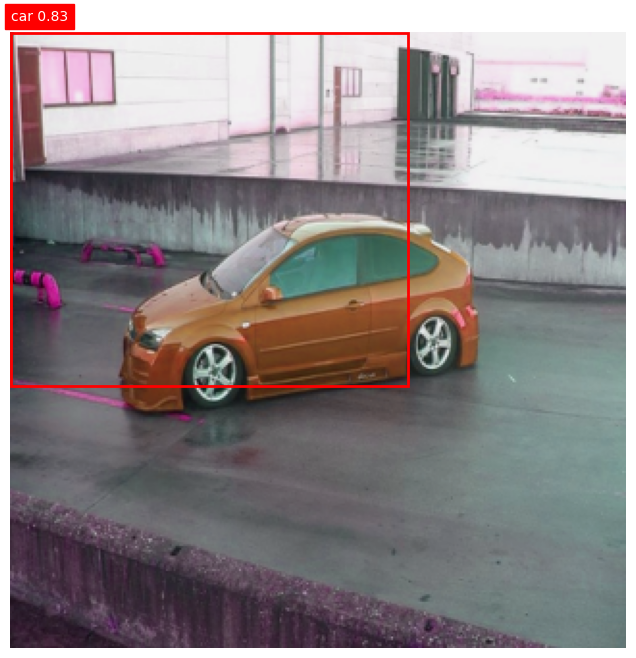

In [96]:
plot_yolo_preds(batch['img'][0], boxes, scores, classes)